In [5]:
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

import gensim
from gensim.models import word2vec

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
from matplotlib import pyplot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import html

In [6]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
#DATA

df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/test.csv")
df_labels = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

In [8]:
# Shuffling data
df = df.sample(frac=1)
# Dropping duplicates & NaN rows
df.drop_duplicates(subset=['text'], inplace=True)
df.dropna(subset = ["text"], inplace=True)
df.dropna(subset = ["title"], inplace=True)

In [10]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
# Removing HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
# Removing all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
# Removing URLs
    clean = re.sub('\W+',' ', clean)                   
# Replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [11]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [12]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

1086     herd stampede wild boar kill islamic state jih...
10091    say russian hacker penetrate file include doss...
18372    russophobia intellectually implode jonas alexi...
19380    brazil arrest terror plot olympics near offici...
23093    reader tell year worth york time explore path ...
                               ...                        
15666    coulter tweet allege illegal immigrant rape fl...
5628     fake news yorker accuse milo incite harassment...
20665    america shit wednesday november gary stanton a...
19896    woman face jail dismal selection office birthd...
25620    money die nightmare weimar collapse tweet home...
Name: clean_joined, Length: 24802, dtype: object


In [35]:
#COUNT VECTORIZER - counts  the occurrence of each word for every single text in order to create a vector

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined, df.label, test_size=0.2)

vectorizer = CountVectorizer(min_df=5, max_df=5000)
vectorizer.fit(df['clean_joined'])
# Transforming training and validation data using count vectorizer object
X_train_count = vectorizer.transform(X_train.values)
X_test_count = vectorizer.transform(X_test.values)


In [65]:
# TF-IDF

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined, df.label, test_size=0.2)

vectorizer = TfidfVectorizer(min_df=5, max_df=5000)
vectorizer.fit(df['clean_joined'])
# Transforming training and validation data using count vectorizer object
X_train_count = vectorizer.transform(X_train.values)
X_test_count = vectorizer.transform(X_test.values)

Model accuracy is :  0.8157629510179399
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      2573
           1       0.84      0.76      0.80      2388

    accuracy                           0.82      4961
   macro avg       0.82      0.81      0.81      4961
weighted avg       0.82      0.82      0.82      4961



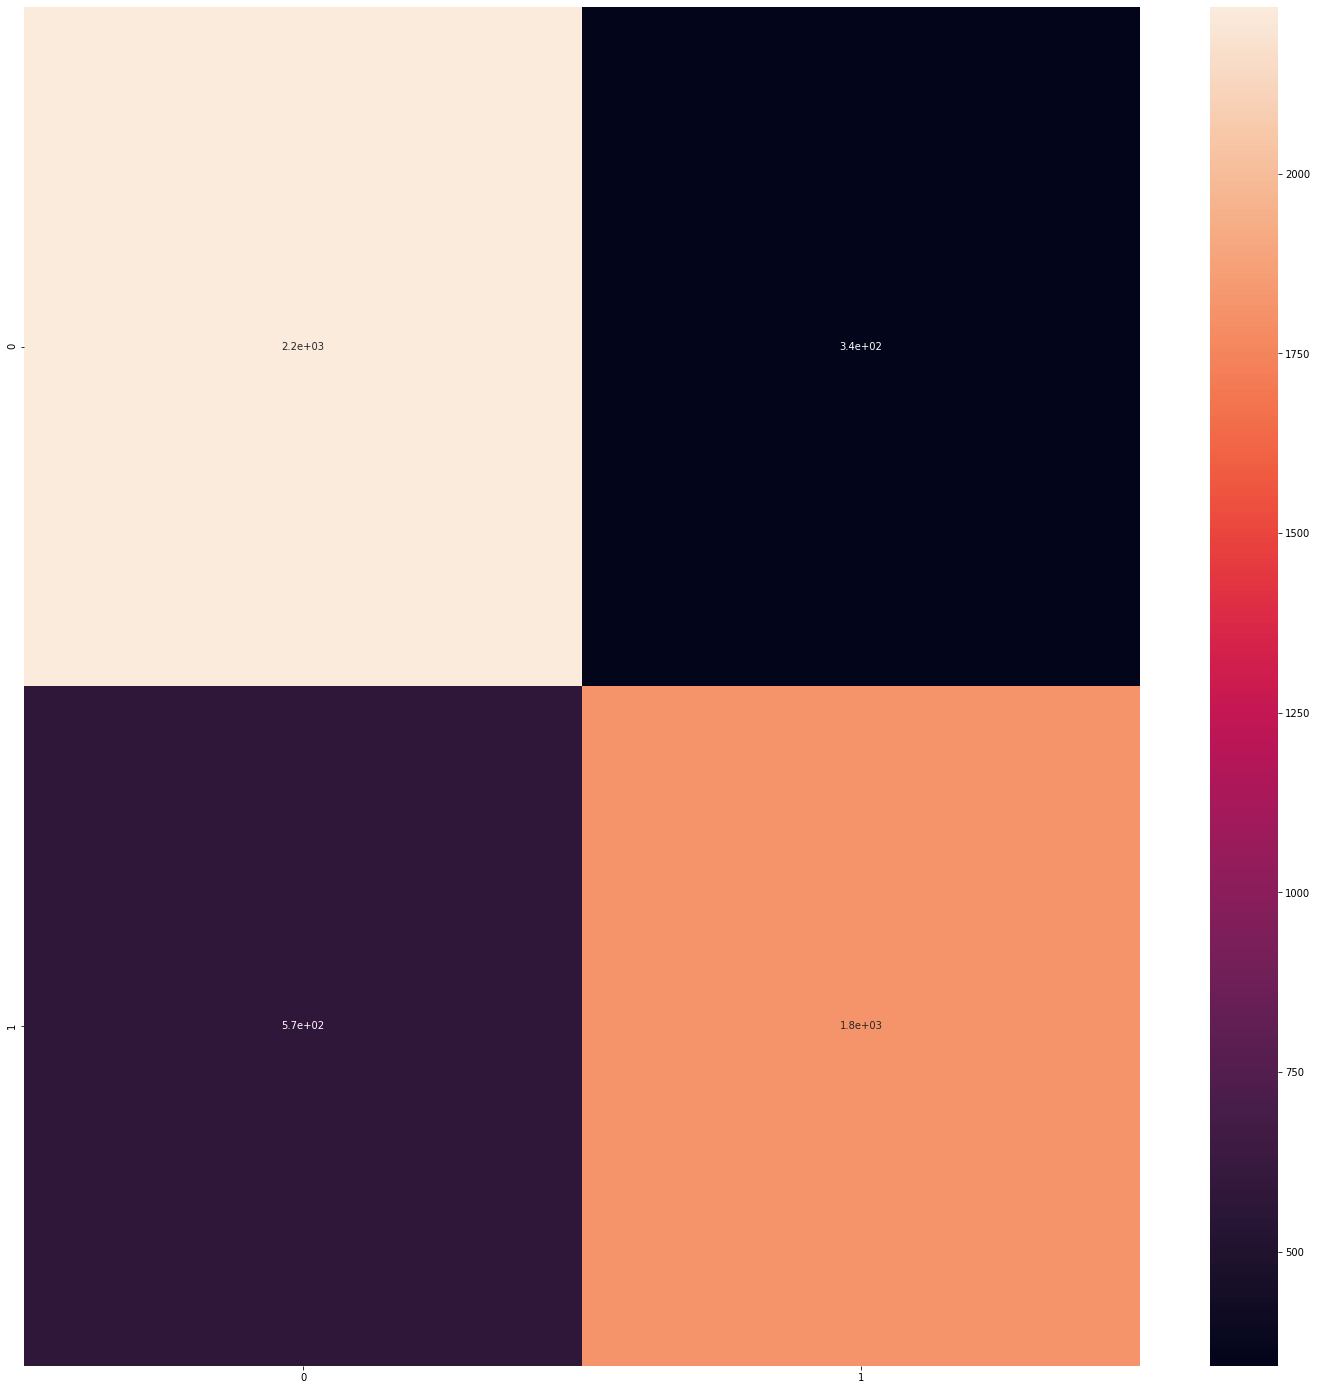

In [92]:
# NAIVE BAYES CLASSIFIER - RESULTS

model = naive_bayes.MultinomialNB()
model.fit(X_train_count, y_train)

# Calculating predictions for a model
pred = model.predict(X_test_count)

prediction = []
# If the prediction > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.885


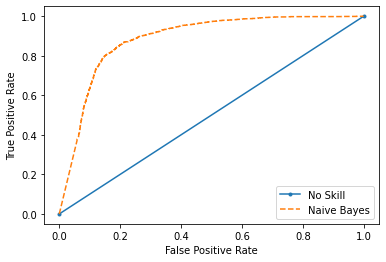

In [99]:
# ROC CURVE

# Generating a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# Predict probabilities for a model
lr_probs = model.predict_proba(X_test_count)
# Keeping probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculating scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# Summarizing scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))

# Calculating roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# Plotting the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, marker='.', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, linestyle='--', label='Naive Bayes')

# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Showing the legend
pyplot.legend()

# Showing the plot
pyplot.show()